In [1]:
import os
import numpy as np

from utilities import PendulumPlant_, DirectCollocationCalculator, LQRController,\
                     TVLQRController, prepare_trajectory, SOSequalityConstrained, get_params
from SosBilinearAlternation import TVmultSearch, TVrhoSearch
from process_data import saveFunnel, prepare_empty
from plots import plotFunnel_fromCsv
from probabilisticMethod import TVprobRhoComputation, TVprobRhoVerification

# Parameters initialization

In [2]:
log_dir = "log_data/direct_collocation"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# get parameters
params_path = "sp_parameters_roa.yaml"
params = get_params(params_path)
data_dict = prepare_empty(params)

# pendulum parameters
mass=params['mass']
length=params['length']
damping=params['damping']
gravity=params['gravity']
coulomb_fric = params['coulomb_fric']
torque_limit=params['torque_limit_control']

# swingup parameters
x0 = [0.0, 0.0]
goal = [np.pi, 0.0]

# direct collocation parameters, N is chosen also to be the number of knot points
N = 60
max_dt = 0.05

# Compute the nominal trajectory via direct collocation

In [3]:
dircal = DirectCollocationCalculator()
dircal.init_pendulum(mass=mass,
                     length=length,
                     damping=damping,
                     gravity=gravity,
                     torque_limit=torque_limit)
x_trajectory, dircol, result = dircal.compute_trajectory(N=N,
                                                         max_dt=max_dt,
                                                         start_state=x0,
                                                         goal_state=goal)
T, X, XD, U = dircal.extract_trajectory(x_trajectory, dircol, result, N=N)

# save results
csv_data = np.vstack((T, X, XD, U)).T
csv_path = os.path.join(log_dir, "trajectory.csv")
np.savetxt(csv_path, csv_data, delimiter=',',
           header="time,pos,vel,torque", comments="")

# load results
csv_path = "log_data/direct_collocation/trajectory.csv"
data_dict = prepare_trajectory(csv_path)
trajectory = np.loadtxt(csv_path, skiprows=1, delimiter=",")
time = trajectory.T[0].T
dt = time[1]-time[0]
x0_traj = [trajectory.T[1].T, trajectory.T[2].T]

# Funnel Computation

In [4]:
def TVSOSrhoBiAlternation(pendulum, controller, time, N, rhof, phi_t, rho_init):

    # Initial rho(t) definition (exponential init)
    # c = 2
    # rho_t = 1.33*np.exp(c*(time-time[-1])/time[-1])
    rho_t = rho_init
    cost_prev = np.inf
    
    # Bilinear SOS alternation for improving the first guess
    convergence = False
    while(not convergence):
        h_maps = []
        gamma_min = 0
        for knot in np.flip([i for i in range(1,round(N))]):
            print("---------------")
            print(f"Multiplier step in knot {knot-1}:")

            fail = True
            while(fail):
                # Search for a multiplier, fixing rho
                (fail, h_map, gamma_i) = TVmultSearch(pendulum, controller, knot, time, rho_t, phi_t)
                if fail:
                    rho_t[knot-1] = 0.8*rho_t[knot-1]
            print(f"The feasible rho is {rho_t[knot-1]}")
            h_maps = np.append(h_map, h_maps)
            gamma_min = 0 #min(gamma_min, gamma_i)

        for knot in np.flip([i for i in range(1,round(N))]):
            print("---------------")
            print(f"V step in knot {knot-1}:")

            fail = True
            while(fail):
                # Search for rho, fixing the multiplier       
                (fail, rho_opt) = TVrhoSearch(pendulum, controller, knot, time, h_maps[knot-1], rho_t, phi_t, gamma_min)
                if fail:
                    gamma_min = 0.75*gamma_min
                    # if (round(gamma_min*10e4) == 0):
                    #     fail = False
                else:
                    print("RHO IMPROVES!!")
            rho_t[knot-1] = rho_opt
        
        # Check for convergence
        eps = 0.1
        if((cost_prev - np.sum(rho_t))/cost_prev < eps): 
            convergence = True  
        cost_prev = np.sum(rho_t)
    
    print("---------------")
    print(f"The final rho is: {rho_t}")
    return (rho_t, controller.tvlqr.S)

---------------
Multiplier step in knot 58:
The feasible rho is 1.946163374386115
---------------
Multiplier step in knot 57:
The feasible rho is 1.8812973696996504
---------------
Multiplier step in knot 56:
The feasible rho is 1.818593361595468
---------------
Multiplier step in knot 55:
The feasible rho is 1.7579792903059834
---------------
Multiplier step in knot 54:
The feasible rho is 1.6993854978297138
---------------
Multiplier step in knot 53:
The feasible rho is 1.6427446478799492
---------------
Multiplier step in knot 52:
The feasible rho is 1.5879916485015408
---------------
Multiplier step in knot 51:
The feasible rho is 1.5350635772668941
---------------
Multiplier step in knot 50:
The feasible rho is 1.4838996089651975
---------------
Multiplier step in knot 49:
The feasible rho is 1.4344409457017695
---------------
Multiplier step in knot 48:
The feasible rho is 1.386630749327225
---------------
Multiplier step in knot 47:
The feasible rho is 1.3404140761187757
-------

/tmp/ipykernel_6511/1899500345.py:46: RuntimeWarning: invalid value encountered in double_scalars
  if((cost_prev - np.sum(rho_t))/cost_prev < eps):


The feasible rho is 2.0615245004131513
---------------
Multiplier step in knot 57:
The feasible rho is 2.013625037323563
---------------
Multiplier step in knot 56:
The feasible rho is 1.9780646752891355
---------------
Multiplier step in knot 55:
The feasible rho is 1.945302627992205
---------------
Multiplier step in knot 54:
The feasible rho is 1.9135050832444709
---------------
Multiplier step in knot 53:
The feasible rho is 1.8732163115371439
---------------
Multiplier step in knot 52:
The feasible rho is 1.82705272026919
---------------
Multiplier step in knot 51:
The feasible rho is 1.777256695485498
---------------
Multiplier step in knot 50:
The feasible rho is 1.7235614203536904
---------------
Multiplier step in knot 49:
The feasible rho is 1.6655025651015258
---------------
Multiplier step in knot 48:
The feasible rho is 1.601987469621877
---------------
Multiplier step in knot 47:
The feasible rho is 1.5310690644772413
---------------
Multiplier step in knot 46:
The feasib

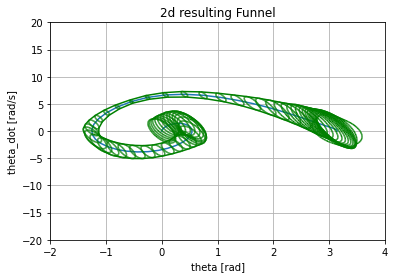

In [5]:
pendulum = PendulumPlant_(mass=mass,
                         length=length,
                         damping=damping,
                         gravity=gravity,
                         coulomb_fric=coulomb_fric,
                         inertia=None,
                         torque_limit=torque_limit)

controller = TVLQRController(data_dict=data_dict, mass=mass, length=length,
                             damping=damping, gravity=gravity,
                             torque_limit=torque_limit)

# Taking the finals values of S and rho from the invariant case, SOS method has been chosen
(rhof, Sf) = SOSequalityConstrained(pendulum,LQRController(mass=mass,
                                                            length=length,
                                                            damping=damping,
                                                            gravity=gravity,
                                                            torque_limit=torque_limit))
controller.set_goal(goal)
S_t = controller.tvlqr.S

phi_t = np.zeros((N,3)) #1e-10*np.ones((N,3))  --- NO S OPTIMIZATION NOW ---

# Application of the algorithm for time-variand RoA estimation
# Initial rho(t) definition (exponential init)
c = 2
rho_init = 15*np.exp(c*(time-time[-1])/time[-1])
rho_init[-1] = rhof
(rho, S) = TVSOSrhoBiAlternation(pendulum, controller, time, N, rhof, phi_t, rho_init)
# nSimulations = 50
# (rho, S_t) = TVprobRhoComputation(pendulum, controller, x0_traj,time, N, nSimulations, rhof)
print("The final rho is: "+str(rho))

# Store the computed funnel
S = S_t.value(time[0]).flatten()
for i in range(1,len(time)):
    S = np.vstack((S,S_t.value(time[i]).flatten()))
saveFunnel(rho, S.T)

# plot the 2d funnel
plotFunnel_fromCsv("log_data/funnel/funnel.csv",x0_traj, time)